<h1 style="font-size:3rem;color:indianred;"> Predicting fraudulent job postings using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not a job posting is fake based on the given attributes.

We're going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Expermentation

<h2><font color=steelblue> 1. Problem Definition </font></h2>

In a statement,
> Given a job posting data, can we predict whether or not it is fake?

<h2><font color=steelblue> 2. Data </font></h2>

The data is available on
[Kaggle](https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction?select=fake_job_postings.csv)

<h2><font color=steelblue> 3. Evaluation </font></h2>

> Reach 90% accuracy at predicting whether or not a job posting is fake during the proof of concept.

<h2><font color=steelblue> 4. Features </font></h2>

This is where you'll get different information about each of the features in your data.

* job_id: unique job id
* title: the title of the job ad entry
* location: geographical location of the job ad
* department: Corporate department (e.g. sales)
* salary_range: indicative salary range (e.g. $50,000-$60,000)
* company_profile: a brief company description
* description: The details description of the job ad
* requirements: enlisted requirements for the job opening
* benefits: enlisted offered benefits by the employer
* telecommuting: True for telecommuting positions
* has_company_logo: True if company logo is present
* has_questions: True if screening questions are present
* employment_type: Full-type, Part-time, Contract, etc
* required_experience: Executive, Entry level, Intern, etc
* required_education: Doctorate, Master’s Degree, Bachelor, etc
* industry: Automotive, IT, Health care, Real estate, etc
* function: Consulting, Engineering, Research, Sales etc
* **fraudulent:** target - Classification attribute

<h3><font color=slateblue> Create dictionary for the features</font></h3>

In [1]:
features = {
    "job_id": "unique job id",
    "title": "the title of the job ad entry",
    "location": "geographical location of the job ad",
    "department": "Corporate department (e.g. sales)",
    "salary_range": "indicative salary range (e.g. $50,000-$60,000)",
    "company_profile": "a brief company description",
    "description": "The details description of the job ad",
    "requirements": "enlisted requirements for the job opening",
    "benefits": "enlisted offered benefits by the employer",
    "telecommuting": "True for telecommuting positions",
    "has_company_logo": "True if company logo is present",
    "has_questions": "True if screening questions are present",
    "employment_type": "Full-type, Part-time, Contract, etc",
    "required_experience": "Executive, Entry level, Intern, etc",
    "required_education": "Doctorate, Master’s Degree, Bachelor, etc",
    "industry": "Automotive, IT, Health care, Real estate, etc",
    "function": "Consulting, Engineering, Research, Sales etc",
    "fraudulent": "target - Classification attribute"
}

<h3><font color=slateblue> Create list for the processed features to indicate order </font></h3>

In [2]:
processed_features = [
    "job_id",
    "title",
    "city",
    "state",
    "country",
    "department",
    "minimum_salary",
    "maximum_salary",
    "company_profile",
    "description",
    "requirements",
    "benefits",
    "telecommuting",
    "has_company_logo",
    "has_questions",
    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
    "fraudulent"
]

<h3><font color=slateblue> Create dictionary for the dataframes </font></h3>

In [3]:
dataframes = {
    "df": "Original dataframe",
    "df_processed": "Clean and processed dataframe",
    "df_balanced": "Balanced dataframe with the same number of fraudulent and real classes",
    "df_cn": "Dataframe that contains the categorical and numerical columns only",
    "df_text": "Dataframe that contains the text columns only"
}

<h2><font color=steelblue>Preparing the tools </font></h2>

We're going to use pandas, matplotlib, NumPy and Seaborn for data analysis and manipulation.

In [4]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline

# Turn the categories into numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Shuffle classes
from sklearn.utils import shuffle

# Models from SciKit-Learn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Natural language processing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

<h2><font color=steelblue> Load data </font></h2>

<h3><font color=slateblue> Read CSV file </font></h3>

In [5]:
df = pd.read_csv("data/fake_job_postings.csv")

<h3><font color=slateblue> Get a sample of the data </font></h3>

In [6]:
df.sample(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
8508,8509,Sr. Estimator,"US, TX, Fort Worth",Industrial Services,NaN,"Founded in 1974 in Canada, and in 1985 in the ...",The position of Sr. Estimator is responsible f...,"To perform this job successfully, an individua...","Base, Bonus, PTO, Retirement, Medical, Dental,...",1,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Construction,Engineering,0
10552,10553,Personal Assistant,"GB, , London",NaN,NaN,We believe cities are complicated. And your mo...,Citymapper is looking for a Personal Assistant...,#NAME?,NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,0
15956,15957,Principal Consultant,"US, CA, San Francisco",NaN,NaN,Talent Response connects flexible professional...,Company BackgroundTalent Response has partnere...,A Principal Consultant must be process-oriente...,NaN,0,1,1,Full-time,Associate,Bachelor's Degree,Management Consulting,Consulting,0
10690,10691,BI Analyst - GetTaxi,NaN,NaN,NaN,NaN,We’re looking for a Senior Business Analyst ex...,Do you have a minimum of 5 years experiences? ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
14151,14152,Media Promotion Trainee,"IN, MP, Indore",Media,180000-240000,"Being into the IT domain for over 4 years, Wal...",If you are creative and conceptual enough to w...,- 1 year experience in media promotion or even...,NaN,0,1,1,Full-time,Entry level,Bachelor's Degree,Information Technology and Services,Art/Creative,0


<h3><font color=slateblue> Get numer of rows and columns </font></h3>

In [7]:
df.shape

(17880, 18)

<h2><font color=steelblue> Data Exploration (exploratory data analysis or EDA)</font></h2>

<h3><font color=slateblue> Get first 5 rows </font></h3>

In [8]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<h3><font color=slateblue> Get last 5 rows </font></h3>

In [9]:
df.tail()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0
17879,17880,Web Application Developers,"NZ, N, Wellington",Engineering,NaN,Vend is looking for some awesome new talent to...,Who are we?Vend is an award winning web based ...,We want to hear from you if:You have an in-dep...,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Engineering,0


<h3><font color=slateblue> Get some info about each column (type, number of null values..)</font></h3>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

<h3><font color=slateblue> Compare the two classes </font></h3>

<h4><font color=darkslategray>Number of fraudulent & non fraudulent job postings</font></h4>

In [11]:
# Let's find out how many of each class there are
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

<h4><font color=darkslategray>Visualize number of fraudulent & non fraudulent job postings in a bar chart</font></h4>

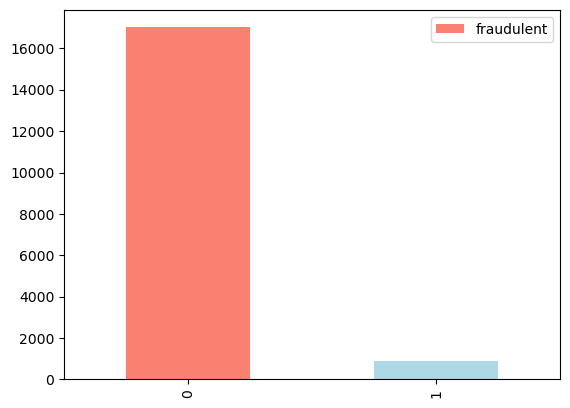

In [12]:
# Visualize the classes with Pandas plot method
df["fraudulent"].value_counts().plot(kind="bar", color=["salmon", "lightblue"], legend=True);

<h4><font color=darkslategray>Visualize number of fraudulent & non fraudulent job postings in a pie chart</font></h4>

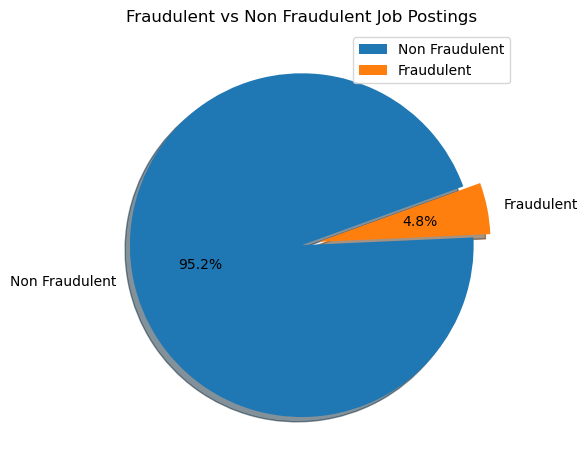

In [13]:
# Visualize the classes in a pie chart
labels = ['Non Fraudulent', 'Fraudulent']
sizes = df["fraudulent"].value_counts()
explode = (0, 0.1)  
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=20)

# Equal aspect ratio ensures that pie is drawn as a circle
# ax.axis('equal')
ax.legend().set_visible(True)

ax.set(title="Fraudulent vs Non Fraudulent Job Postings")
plt.tight_layout()
plt.show()

In [14]:
# kwargs = dict(
#     startangle = 90,
#     colormap   = 'Pastel2',
#     fontsize   = 12,
#     shadow     = True,
#     explode    = (0.08, 0.08),
#     figsize    = (60, 5),
#     autopct    = '%1.1f%%',
#     title      = 'Fraudulent vs non fraudulent job postings',
#     ylabel     = '',
#     legend     = True,
#     labeldistance = None
# )

# ax = df['fraudulent'].value_counts().plot.pie(**kwargs);

# ax.legend(bbox_to_anchor = (1, 1.02), loc='best')
# ax

As we can see, the classes are highly imbalanced.

<h3><font color=slateblue> Check mising values </font></h3>

In [15]:
# Are there any missing values?
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<h3><font color=slateblue> Fraudulent job postings Frequency according to industry</font></h3>

<h4><font color=darkslategray>Number of industries</font></h4>

In [16]:
# number of industries
df.industry.value_counts()

Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
                                       ... 
Shipbuilding                              1
Sporting Goods                            1
Museums and Institutions                  1
Wine and Spirits                          1
Ranching                                  1
Name: industry, Length: 131, dtype: int64

<h4><font color=darkslategray>Categories of industry</font></h4>

In [17]:
# Categories of industry
df["industry"].unique()

array([nan, 'Marketing and Advertising', 'Computer Software',
       'Hospital & Health Care', 'Online Media',
       'Information Technology and Services', 'Financial Services',
       'Management Consulting', 'Events Services', 'Internet',
       'Facilities Services', 'Consumer Electronics',
       'Telecommunications', 'Consumer Services', 'Construction',
       'Oil & Energy', 'Education Management', 'Building Materials',
       'Banking', 'Food & Beverages', 'Food Production',
       'Health, Wellness and Fitness', 'Insurance', 'E-Learning',
       'Cosmetics', 'Staffing and Recruiting',
       'Venture Capital & Private Equity', 'Leisure, Travel & Tourism',
       'Human Resources', 'Pharmaceuticals', 'Farming', 'Legal Services',
       'Luxury Goods & Jewelry', 'Machinery', 'Real Estate',
       'Mechanical or Industrial Engineering',
       'Public Relations and Communications', 'Consumer Goods',
       'Medical Practice', 'Electrical/Electronic Manufacturing',
       'Hospita

<h4><font color=darkslategray>Number of fake job postings per industry</font></h4>

In [18]:
# Number of fake job postings per industry
df.industry[df["fraudulent"] == 1].value_counts()

Oil & Energy                   109
Accounting                      57
Hospital & Health Care          51
Marketing and Advertising       45
Financial Services              35
                              ... 
Civic & Social Organization      1
Public Safety                    1
Wholesale                        1
Consumer Goods                   1
Online Media                     1
Name: industry, Length: 62, dtype: int64

<h4><font color=darkslategray>Fake job postings VS. industry</font></h4>

In [19]:
# Compare fraudulent column with industry column
pd.crosstab(index=df.fraudulent, 
            columns=df.industry)

industry,Accounting,Airlines/Aviation,Alternative Dispute Resolution,Animation,Apparel & Fashion,Architecture & Planning,Automotive,Aviation & Aerospace,Banking,Biotechnology,...,Translation and Localization,Transportation/Trucking/Railroad,Utilities,Venture Capital & Private Equity,Veterinary,Warehousing,Wholesale,Wine and Spirits,Wireless,Writing and Editing
fraudulent,,,,,,,,,,,,,,,,,,,,,
0,102,62,1,3,95,10,115,24,81,34,...,10,50,32,29,8,50,10,1,4,19
1,57,1,0,2,2,0,5,0,3,4,...,0,3,1,0,0,1,1,0,0,0


Since there are too many industries to visualize on graph, let's get the top 10

<h4><font color=darkslategray>Top 10 industries that have the highest number of fake job postings</font></h4>

In [20]:
# Get top 10 industries that have the highest number of fake job postings
# top_fraudulent_industries = df.fraudulent[df.fraudulent == 1].groupby(df['industry']).value_counts().sort_values(ascending=False).head(10)

top_fraudulent_industries = df.industry[df["fraudulent"] == 1].value_counts().head(10)

top_fraudulent_industries

Oil & Energy                           109
Accounting                              57
Hospital & Health Care                  51
Marketing and Advertising               45
Financial Services                      35
Information Technology and Services     32
Telecommunications                      26
Real Estate                             24
Consumer Services                       24
Leisure, Travel & Tourism               21
Name: industry, dtype: int64

<h4><font color=darkslategray>Visualize top 10 industries that have the highest number of fake job postings</font></h4>

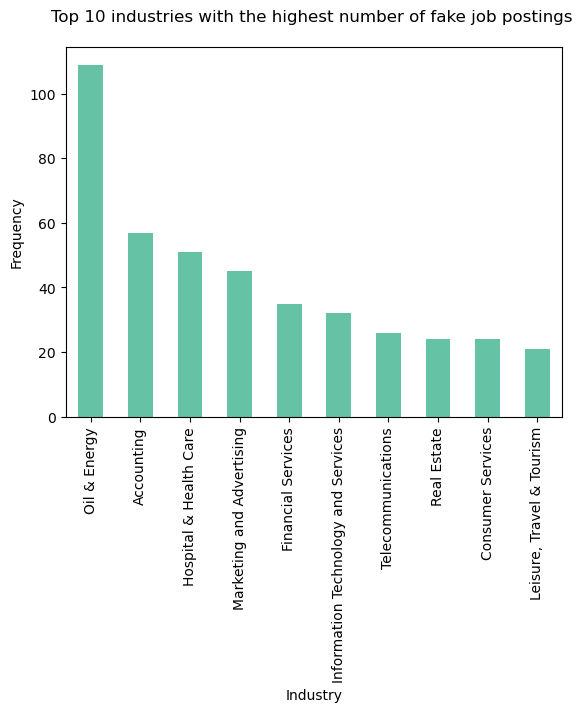

In [21]:
# Visualize top 10 industries that have the highest number of fake job postings
top_fraudulent_industries.plot.bar();

top_fraudulent_industries.plot(kind='bar',
#                                 figsize=(10, 8),
                                title="Top 10 industries with the highest number of fake job postings \n",
                                colormap="Set2",
                                xlabel="Industry",
                                ylabel="Frequency");

Oil & energy and accounting industries have the highest number of fake job postings.

In [22]:
# industries = df[df.fraudulent == 1].groupby(['industry']).agg({'fraudulent': 'sum'})
# industries

In [23]:
# sns.violinplot(data=df, x="industry", y="fraudulent", cut=0)
# sns.violinplot(data=df, x="fraudulent", y="required_experience", scale="count")

<h3><font color=slateblue> Fraudulent job postings Frequency according to employment type</font></h3>

<h4><font color=darkslategray>Number of employment types</font></h4>

In [24]:
df.employment_type.value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

<h4><font color=darkslategray>Categories of employment type</font></h4>

In [25]:
df["employment_type"].unique()

array(['Other', 'Full-time', nan, 'Part-time', 'Contract', 'Temporary'],
      dtype=object)

<h4><font color=darkslategray>Visualize categories of employment type</font></h4>

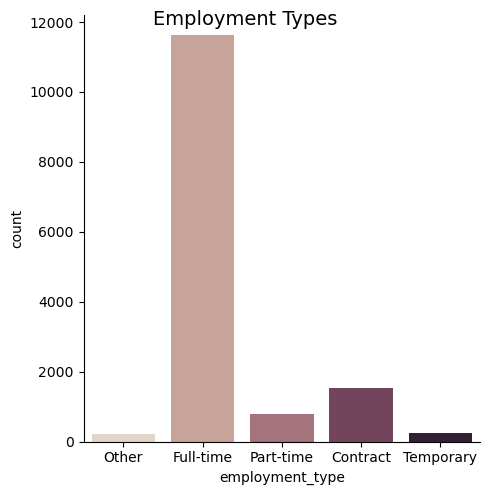

In [26]:
employment_types_graph = sns.catplot(data=df, x="employment_type", kind="count", palette="ch:.25");
employment_types_graph.fig.suptitle("Employment Types", fontsize=14);

<h4><font color=darkslategray>Categories of employment type VS. Fraudulent</font></h4>

In [27]:
pd.crosstab(df.employment_type, df.fraudulent)

fraudulent,0,1
employment_type,,
Contract,1480,44
Full-time,11130,490
Other,212,15
Part-time,723,74
Temporary,239,2


<h4><font color=darkslategray>Visualize categories of employment type VS. Fraudulent</font></h4>

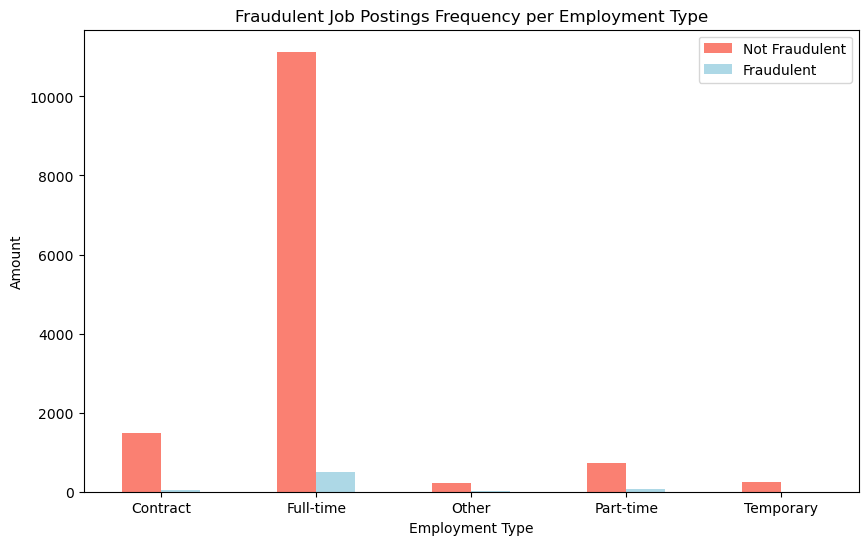

In [28]:
# Make the crosstab more visual
pd.crosstab(df.employment_type, df.fraudulent).plot(kind="bar",
                                  figsize=(10, 6),
                                  color=["salmon", "lightblue"]);

# Add some communication
plt.title("Fraudulent Job Postings Frequency per Employment Type")
plt.xlabel("Employment Type")
plt.ylabel("Amount")
plt.legend(["Not Fraudulent", "Fraudulent"])
plt.xticks(rotation=0);

Full time and part time jobs have the highest number of fake job postings.

<h3><font color=slateblue> Fraudulent job postings Frequency according to required experience</font></h3>

<h4><font color=darkslategray>Number of required experiences</font></h4>

In [29]:
df.required_experience.value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

<h4><font color=darkslategray>Categories of required experience</font></h4>

In [30]:
df["required_experience"].unique()

array(['Internship', 'Not Applicable', nan, 'Mid-Senior level',
       'Associate', 'Entry level', 'Executive', 'Director'], dtype=object)

<h4><font color=darkslategray>Categories of required experience VS. Fraudulent</font></h4>

In [31]:
pd.crosstab(df.required_experience, df.fraudulent)

fraudulent,0,1
required_experience,,
Associate,2255,42
Director,372,17
Entry level,2518,179
Executive,131,10
Internship,371,10
Mid-Senior level,3696,113
Not Applicable,1056,60


<h4><font color=darkslategray>Visualize categories of employment type VS. Fraudulent</font></h4>

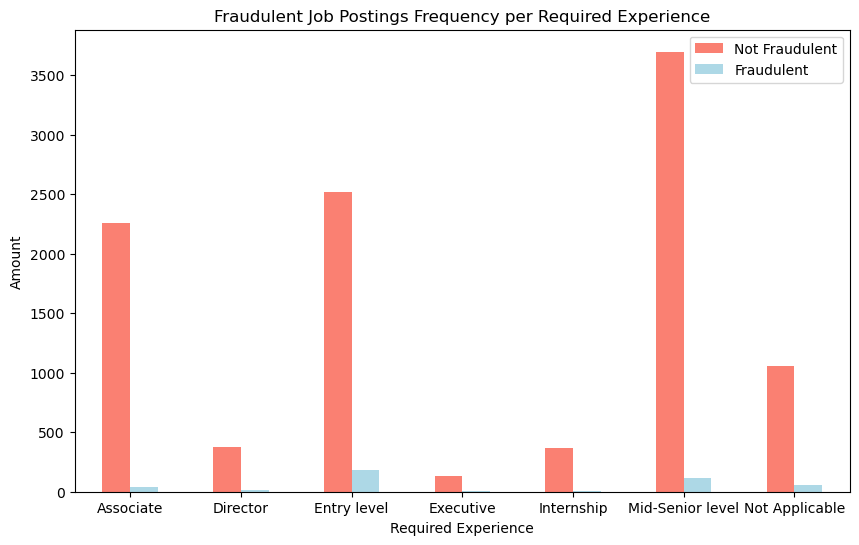

In [32]:
# Make the crosstab more visual
pd.crosstab(df.required_experience, df.fraudulent).plot(kind="bar",
                                  figsize=(10, 6),
                                  color=["salmon", "lightblue"]);

# Add some communication
plt.title("Fraudulent Job Postings Frequency per Required Experience")
plt.xlabel("Required Experience")
plt.ylabel("Amount")
plt.legend(["Not Fraudulent", "Fraudulent"])
plt.xticks(rotation=0);

Entry and mid-senior levels have the highest number of fake job postings.

<h3><font color=slateblue> Fraudulent job postings Frequency according to function</font></h3>

<h4><font color=darkslategray>Number of functions</font></h4>

In [33]:
df.function.value_counts()

Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Writing/Editing            132
Art/Creative               132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38
Supply C

<h4><font color=darkslategray>Categories of function</font></h4>

In [34]:
df["function"].unique()

array(['Marketing', 'Customer Service', nan, 'Sales',
       'Health Care Provider', 'Management', 'Information Technology',
       'Other', 'Engineering', 'Administrative', 'Design', 'Production',
       'Education', 'Supply Chain', 'Business Development',
       'Product Management', 'Financial Analyst', 'Consulting',
       'Human Resources', 'Project Management', 'Manufacturing',
       'Public Relations', 'Strategy/Planning', 'Advertising', 'Finance',
       'General Business', 'Research', 'Accounting/Auditing',
       'Art/Creative', 'Quality Assurance', 'Data Analyst',
       'Business Analyst', 'Writing/Editing', 'Distribution', 'Science',
       'Training', 'Purchasing', 'Legal'], dtype=object)

<h4><font color=darkslategray>Categories of function VS. Fraudulent</font></h4>

In [35]:
pd.crosstab(df.function, df.fraudulent)

fraudulent,0,1
function,,
Accounting/Auditing,183,29
Administrative,511,119
Advertising,85,5
Art/Creative,131,1
Business Analyst,83,1
Business Development,215,13
Consulting,140,4
Customer Service,1162,67
Data Analyst,78,4


<h3><font color=slateblue> Fraudulent job postings Frequency according to Required Education</font></h3>

<h4><font color=darkslategray>Number of required educations</font></h4>

In [36]:
df.required_education.value_counts()

Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

<h4><font color=darkslategray>Categories of required education</font></h4>

In [37]:
df["required_education"].unique()

array([nan, "Bachelor's Degree", "Master's Degree",
       'High School or equivalent', 'Unspecified',
       'Some College Coursework Completed', 'Vocational', 'Certification',
       'Associate Degree', 'Professional', 'Doctorate',
       'Some High School Coursework', 'Vocational - Degree',
       'Vocational - HS Diploma'], dtype=object)

<h4><font color=darkslategray>Categories of required education VS. Fraudulent</font></h4>

In [38]:
pd.crosstab(df.required_education, df.fraudulent)

fraudulent,0,1
required_education,,
Associate Degree,268,6
Bachelor's Degree,5045,100
Certification,151,19
Doctorate,25,1
High School or equivalent,1910,170
Master's Degree,385,31
Professional,70,4
Some College Coursework Completed,99,3
Some High School Coursework,7,20


<h3><font color=slateblue> Correlation between numerical columns </font></h3>

<h4><font color=darkslategray>Correlation table</font></h4>

In [39]:
df.corr()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
job_id,1.000000,-0.004559,-0.014539,-0.087025,0.079872
telecommuting,-0.004559,1.000000,-0.019836,0.020345,0.034523
has_company_logo,-0.014539,-0.019836,1.000000,0.233932,-0.261971
has_questions,-0.087025,0.020345,0.233932,1.000000,-0.091627
fraudulent,0.079872,0.034523,-0.261971,-0.091627,1.000000


<h4><font color=darkslategray>Visualize correlation table</font></h4>

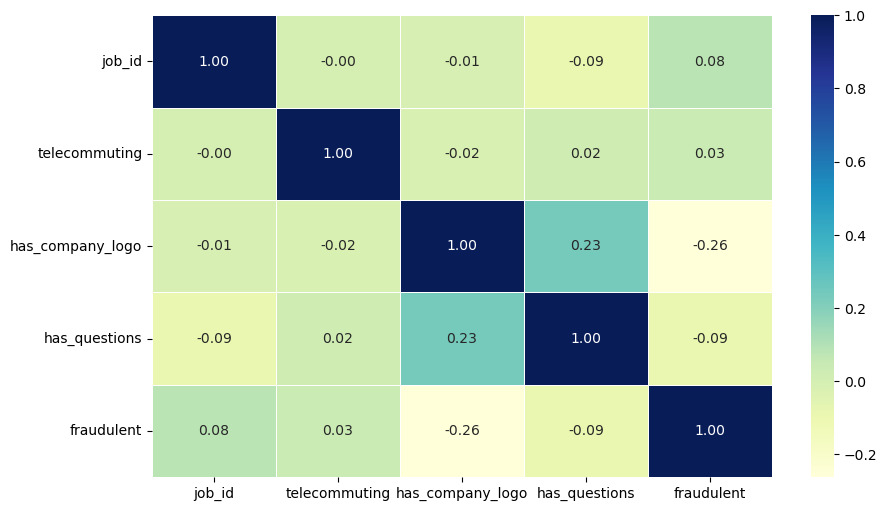

In [40]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

The correlation matrix does not show any strong positive or negative correlations between the numerical data.

<h2><font color=steelblue> Data cleaning </font></h2>

1. Clean Nan values (department, salary_range, benefits, requirements, benefits, employment_type, required_experiece, required_education, industry, function)
2. Categorical columns need to be seperated (employment_type, industry, function, department).
3. Salary range needs to be seperated into minimum and maximum.
4. Location needs to be seperated.
5. Natural Language processing for company_profile, description, requirements and benefits columns.

<h3><font color=slateblue> Get a sample of the data </font></h3>

In [41]:
df.sample(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
4237,4238,Senior Associate Corporate Finance & Planning,"PK, IS, Islamabad",Finance,NaN,NaN,Position Title: Senior Associate Corporate Fin...,Essential Requirements:-- Experience in IPP (I...,NaN,0,0,1,NaN,NaN,NaN,NaN,NaN,0
12712,12713,Scala Platform Engineer,"US, NY, New York",NaN,100000-130000,Recombine provides clinical genetic testing. C...,Recombine is advancing personalized medicine b...,Expert level experience in Scala.Experience de...,Participate and contribute to an environment w...,0,1,1,Full-time,Not Applicable,NaN,Computer Software,Engineering,0
6765,6766,Sales Development Representative - Germany,"DE, BY, Munich",NaN,NaN,Cloudreach are the only top tier partner of ch...,What we are looking for?As an Internal Sales E...,What do you need to bring to the table?Persona...,Why do you want to work with us?You want to be...,0,1,0,Full-time,Associate,Bachelor's Degree,Information Technology and Services,Sales,0
14315,14316,Mobile Developer,"JP, 13, Tokyo",Engineer,NaN,We are an digital product agency specialising ...,Favorite Medium is a digital product consultan...,"Deep Android and/or iOS SDK experienceJava, C,...",NaN,1,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Engineering,0
7146,7147,English Teacher Abroad,"US, VA, Ettrick",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,NaN,0


<h3><font color=slateblue> Create a copy of the dataframe to keep the original as is </font></h3>

In [42]:
df_processed = df.copy()

<h3><font color=slateblue> Type of columns </font></h3>

In [43]:
df_processed.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

<h3><font color=slateblue> Check mising values </font></h3>

In [44]:
df_processed.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<h3><font color=slateblue> Seperate location then drop it</font></h3>

In [45]:
df_processed[["country", "state", "city"]] = df_processed["location"].str.split(",", n=2, expand=True)
df_processed.drop('location', axis=1, inplace=True)

<h3><font color=slateblue> Get a sample of the data </font></h3>

In [46]:
df_processed.sample(5)

,job_id,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
13486,13487,Linux Systems/Security Engineer,NaN,NaN,Roka Security is a boutique security firm that...,"We are a growing team of Security, Linux, and ...",Specific Technical Expertise and Knowledge Req...,Competitive CompensationMedical and DentalLife...,0,1,1,Full-time,Mid-Senior level,Unspecified,Computer & Network Security,Information Technology,0,US,VA,Herndon
15819,15820,Contract Android Developer,Android,NaN,"We're an emerging technology agency, and we bu...",We’re always open to connecting with experienc...,You will excel in this position if:You have at...,"You’ll love working here, because this isn’t a...",0,1,1,Contract,Mid-Senior level,NaN,Computer Software,Engineering,0,US,TX,Austin
14504,14505,Account and Biz Development Manager,NaN,NaN,Fnatic was founded in 2004 and is an ambitious...,"Duties:Working for a dynamic eSports company, ...",Skills/Qualifications:Experience speaking and ...,Fantastic London office in ShoreditchRegular T...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Marketing and Advertising,Management,0,GB,LND,London
11157,11158,Senior Computer Vision/Machine Learning Progra...,NaN,90000-130000,NaN,Fashion Metric is looking for a Computer Visio...,The ideal candidate would have a PhD in Comput...,NaN,0,0,0,Full-time,Director,Master's Degree,Computer Software,Engineering,0,US,TX,Austin
5032,5033,Tech Lead- Java/ J2EE,Software / IT,NaN,About LocationGuru Solutions Pvt. Ltd Location...,Responsibilities: Lead team across multiple su...,Requirements: Knowledge on all aspects of Soft...,"Working with one of the niche domain ""Location...",0,1,1,NaN,NaN,NaN,NaN,NaN,0,IN,MH,Mumbai


<h3><font color=slateblue> Seperate salary range into minimum and maximum and Cast type to integer</font></h3>

In [47]:
df_processed[["minimum_salary", "maximum_salary"]] = df_processed["salary_range"].str.split("-", n=1, expand=True)

<h3><font color=slateblue> Drop salary range </font></h3>

In [48]:
df_processed.drop('salary_range', axis=1, inplace=True)

<h3><font color=slateblue> Get a sample of the data </font></h3>

In [49]:
df_processed.sample(5)

,job_id,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,required_experience,required_education,industry,function,fraudulent,country,state,city,minimum_salary,maximum_salary
4789,4790,Sales Representative,NaN,NaN,"Westview Financial Services, located in Chesap...",The qualifications for this position are: • A ...,We offer a competitive salary as well as a com...,0,0,0,...,Associate,Unspecified,Financial Services,Sales,0,US,VA,Chesapeake,NaN,NaN
11900,11901,Program Manager - Saxo Bank,NaN,NaN,Saxo Bank is looking for an experienced and su...,Your profil Has a Msc (or higher) degree in En...,"We offerFirst and foremost, we offer more than...",0,1,0,...,Mid-Senior level,Master's Degree,Banking,Project Management,0,DK,,,750000,1200000
9540,9541,English Teacher Abroad,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,...,NaN,Bachelor's Degree,Education Management,NaN,0,US,PA,State College,NaN,NaN
948,949,Web Developer - Frontend,NaN,"codebender is an online platform for makers, h...",We are looking for a PHP/HTML/JS developer who...,"Good knowledge of HTML, CSS, JavascriptKnownle...","As an employee of codebender, you are entitled...",0,1,1,...,Entry level,High School or equivalent,Computer Software,Engineering,0,GR,J,Patra,9600,18000
11076,11077,Financial Controller,NaN,ustwo offers you the opportunity to be yoursel...,ustwo loves data and as we become more operati...,"Major Plus - experience in a creative studio, ...",NaN,0,1,1,...,Mid-Senior level,NaN,NaN,Finance,0,US,NY,New York,NaN,NaN


<h3><font color=slateblue> Fill Minimum and Maximum salary columns and Convert them to integers </font></h3>

In [50]:
# Fill Minimum and Maximum salary columns
df_processed["minimum_salary"].fillna(-1, inplace=True)
df_processed["maximum_salary"].fillna(-1, inplace=True)

# Fill in random text data in salary columns
df_processed.loc[df_processed['minimum_salary']  == "Oct", "minimum_salary"] = -1
df_processed.loc[df_processed['minimum_salary']  == "Jun", "minimum_salary"] = -1
df_processed.loc[df_processed['minimum_salary']  == "Dec", "minimum_salary"] = -1

df_processed.loc[df_processed['maximum_salary']  == "Dec", "maximum_salary"] = -1
df_processed.loc[df_processed['maximum_salary']  == "Apr", "maximum_salary"] = -1
df_processed.loc[df_processed['maximum_salary']  == "Sep", "maximum_salary"] = -1
df_processed.loc[df_processed['maximum_salary']  == "Jun", "maximum_salary"] = -1
df_processed.loc[df_processed['maximum_salary']  == "Oct", "maximum_salary"] = -1
df_processed.loc[df_processed['maximum_salary']  == "Nov", "maximum_salary"] = -1

# Convert salary columns to integers
df_processed["minimum_salary"] = df_processed["minimum_salary"].astype(int)
df_processed["maximum_salary"] = df_processed["maximum_salary"].astype(int)

<h3><font color=slateblue> Get columns types </font></h3>

In [51]:
df_processed.dtypes

job_id                  int64
title                  object
department             object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
country                object
state                  object
city                   object
minimum_salary          int32
maximum_salary          int32
dtype: object

<h3><font color=slateblue> Reorder columns </font></h3>

In [52]:
df_processed = df_processed.reindex(processed_features, axis=1)

<h3><font color=slateblue> Get a sample of the data </font></h3>

In [53]:
df_processed.sample(5)

,job_id,title,city,state,country,department,minimum_salary,maximum_salary,company_profile,description,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17043,17044,Small Electronic Device Repair Person,Minden,NV,US,NaN,22000,30000,NaN,We are a local company looking for an energeti...,...,NaN,0,0,0,Full-time,NaN,NaN,Warehousing,NaN,0
13115,13116,Agile Coach,,,GB,OPS,-1,-1,"We experiment with new digital products, retai...",Are you passionate about all things agile and ...,...,What’s in it for You?Play a significant role i...,0,1,0,Contract,Not Applicable,NaN,Internet,Consulting,0
15878,15879,Retail Store Manager,Greenwood,SC,US,NaN,-1,-1,NaN,"Working independently, the Store Manager direc...",...,NaN,0,0,0,Full-time,Associate,High School or equivalent,Retail,Management,0
11214,11215,District Manager Assistant,Virginia Beach,VA,US,NaN,-1,-1,NaN,"Westview Financial Services, located in Virgin...",...,We offer a competitive salary based on experie...,0,0,0,Full-time,Entry level,Unspecified,Financial Services,Administrative,0
3904,3905,Full stack engineer,San Francisco,CA,US,NaN,80000,110000,"We are a small, dedicated and product-focused ...",About RainforestRainforest is a better way to ...,...,"As a 3 person company, our culture is in const...",0,1,1,Full-time,Not Applicable,NaN,Internet,Engineering,0


<h3><font color=slateblue> Get fraudulent jobs per country </font></h3>

<h4><font color=darkslategray>Number of job postings per country</font></h4>

In [54]:
df_processed.country.value_counts()

US    10656
GB     2384
GR      940
CA      457
DE      383
      ...  
SI        1
PE        1
SD        1
UG        1
KH        1
Name: country, Length: 90, dtype: int64

<h4><font color=darkslategray>Number of fraudulent jobs per country</font></h4>

In [55]:
pd.crosstab(index=df_processed.fraudulent, 
            columns=df_processed.country)

country,AE,AL,AM,AR,AT,AU,BD,BE,BG,BH,...,TR,TT,TW,UA,UG,US,VI,VN,ZA,ZM
fraudulent,,,,,,,,,,,,,,,,,,,,,
0,53,1,2,9,14,174,2,117,17,4,...,17,4,2,13,1,9926,3,4,39,2
1,1,0,0,0,0,40,0,0,0,5,...,0,0,2,0,0,730,0,0,1,0


<h4><font color=darkslategray>Top 10 countries that have the highest number of fake job postings</font></h4>

In [56]:
top_fraudulent_countries = df_processed.country[df_processed["fraudulent"] == 1].value_counts().head(10)

top_fraudulent_countries

US    730
AU     40
GB     23
MY     12
CA     12
QA      6
BH      5
IN      4
PL      3
TW      2
Name: country, dtype: int64

<h4><font color=darkslategray>Visualize top 10 countries that have the highest number of fake job postings</font></h4>

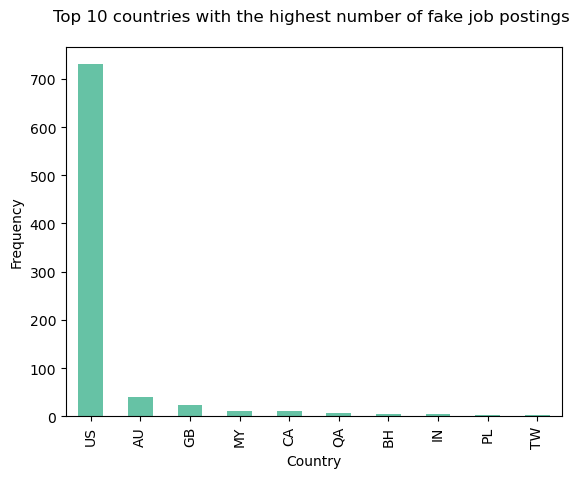

In [57]:
# Visualize top 10 industries that have the highest number of fake job postings
top_fraudulent_countries.plot.bar();

top_fraudulent_countries.plot(kind='bar',
#                                 figsize=(10, 8),
                                title="Top 10 countries with the highest number of fake job postings \n",
                                colormap="Set2",
                                xlabel="Country",
                                ylabel="Frequency");

<h3><font color=slateblue> Process data by filling missing data and converting data to numbers </font></h3>

In [58]:
cat = pd.Categorical(['title', 'department', 'employment_type', "required_experience", "required_education", "industry", "function", "country", "state", "city"])

def preprocess_data(df):
    """
    Process data by filling in missing numerical columns with -1
    and turning categorical columns into numbers
    """
    for label, content in df.items():
        # Fill missing numerical values with -1
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(-1)
                
        # Fill categorical missing data and turn categories into numbers
        elif df[label].name in cat:
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1   
        
        # Fill in text data
        elif pd.api.types.is_string_dtype(content):
            if pd.isnull(content).sum():
#                 df[label] = content.fillna("Unspecified")
                df[label] = content.fillna("")
                
        # Fill categorical missing data and turn categories into numbers
#         if not pd.api.types.is_numeric_dtype(content): 
#             # We add the +1 because pandas encodes missing categories as -1
#             df[label] = pd.Categorical(content).codes+1       
    
    return df

In [59]:
preprocess_data(df_processed)

,job_id,title,city,state,country,department,minimum_salary,maximum_salary,company_profile,description,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,6044,1459,229,86,759,-1,-1,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",...,,0,1,0,3,5,0,0,23,0
1,2,2184,190,1,61,1162,-1,-1,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,...,What you will get from usThrough being part of...,0,1,0,2,7,0,76,8,0
2,3,1764,2214,157,86,0,-1,-1,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",...,,0,1,0,0,0,0,0,0,0
3,4,300,2165,106,86,1055,-1,-1,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,...,Our culture is anything but corporate—we have ...,0,1,0,2,6,2,23,32,0
4,5,976,788,132,86,0,-1,-1,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,...,Full Benefits Offered,0,1,1,2,6,2,52,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,269,2083,236,13,1055,-1,-1,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,...,What can you expect from us?We have an open cu...,0,1,1,2,6,0,23,32,0
17876,17877,7102,1631,240,86,63,-1,-1,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,...,Health &amp; WellnessMedical planPrescription ...,0,1,1,2,6,2,62,1,0
17877,17878,7580,977,290,86,0,-1,-1,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,...,,0,0,0,2,0,0,0,0,0
17878,17879,4108,1116,177,57,0,-1,-1,,Nemsia Studios is looking for an experienced v...,...,Competitive salary (compensation will be based...,0,0,1,1,7,7,49,10,0


<h3><font color=slateblue> View types </font></h3>

In [60]:
df_processed.dtypes

job_id                  int64
title                   int16
city                    int16
state                   int16
country                  int8
department              int16
minimum_salary          int32
maximum_salary          int32
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type          int8
required_experience      int8
required_education       int8
industry                int16
function                 int8
fraudulent              int64
dtype: object

<h3><font color=slateblue> Drop text columns for now </font></h3>

Natural language processing will come later.

In [61]:
df_cn = df_processed.drop(["company_profile", "requirements", "benefits", "description", "job_id", "title"], axis=1)

<h3><font color=slateblue> Get columns </font></h3>

In [62]:
df_cn.columns

Index(['city', 'state', 'country', 'department', 'minimum_salary',
       'maximum_salary', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'required_experience', 'required_education',
       'industry', 'function', 'fraudulent'],
      dtype='object')

<h3><font color=slateblue> Get a sample of the data </font></h3>

In [63]:
df_cn.sample(5)

,city,state,country,department,minimum_salary,maximum_salary,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17088,1,1,28,1198,45,55,0,0,1,2,6,10,62,19,0
6712,1,1,86,0,-1,-1,0,1,1,2,2,2,50,8,0
3715,1459,229,86,0,-1,-1,0,1,0,2,6,2,40,21,0
2550,190,206,61,336,90000,110000,0,1,1,2,6,2,59,19,0
9592,524,232,86,0,-1,-1,0,0,0,2,0,0,59,0,0


<h3><font color=slateblue> Correlation of numerical variables </font></h3>

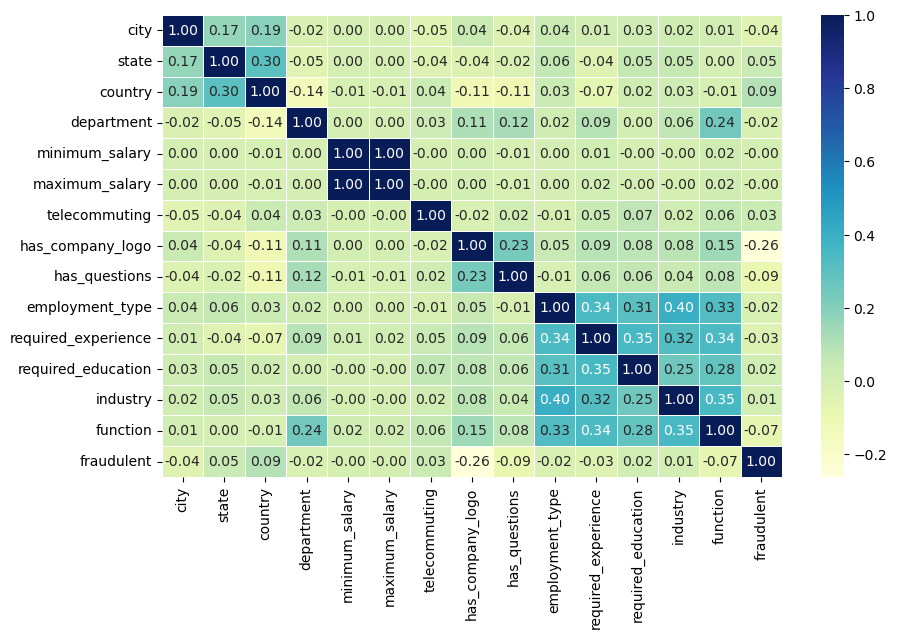

In [64]:
corr_matrix = df_cn.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

<h3><font color=slateblue> Balance classes </font></h3>

In [65]:
np.random.seed(42)

df_real = df_cn[df_cn.fraudulent == 0].sample(865)
df_fake = df_cn[df_cn.fraudulent == 1]

df_balanced = pd.concat([df_real, df_fake], ignore_index=True, sort=False)

# shuffle classes
df_balanced = shuffle(df_balanced)

df_balanced.head(10)

,city,state,country,department,minimum_salary,maximum_salary,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
1198,638,157,86,0,-1,-1,0,0,0,2,0,0,0,0,1
1133,2043,132,86,0,-1,-1,0,0,1,0,0,0,0,0,1
1526,1,85,86,0,-1,-1,0,0,0,2,0,0,59,0,1
10,545,232,86,0,-1,-1,0,1,1,2,6,5,108,0,0
1043,1,184,28,568,-1,-1,0,0,0,0,0,0,0,0,1
1306,1767,191,86,0,-1,-1,0,0,0,1,0,0,108,0,1
513,317,158,86,389,-1,-1,0,1,1,0,0,0,76,3,0
499,1192,184,28,0,-1,-1,0,1,1,2,6,2,40,23,0
228,459,1,25,0,-1,-1,0,0,0,2,6,0,34,0,0
929,977,290,86,0,-1,-1,0,1,0,2,0,0,89,13,1


<h2><font color=steelblue> Modelling </font></h2>

Since it is a classification problem, here are the available models from SciKit Learn.

<div>
<img src="images/classification-map.png" width="500"/>
</div>

<h3><font color=slateblue> LinearSVC </font></h3>

<h4><font color=darkslategray> Train model </font></h4>

In [66]:
# Let's build a machine learning model
X = df_balanced.drop("fraudulent", axis=1)
y = df_balanced["fraudulent"]

# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

model = LinearSVC(dual=False)

model.fit(X_train, y_train)

LinearSVC(dual=False)

<h4><font color=darkslategray> Score training set </font></h4>

In [67]:
model.score(X_train, y_train)

0.7427745664739884

<h4><font color=darkslategray> Score test set </font></h4>

1. Accuracy

In [68]:
model.score(X_test, y_test)

0.723342939481268

2. Confusion matrix

In [69]:
y_preds = model.predict(X_test)

In [70]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[144  37]
 [ 59 107]]


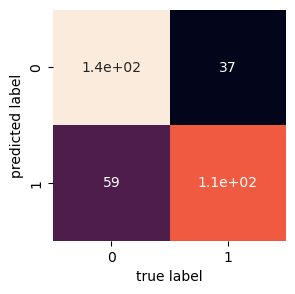

In [71]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True, # Annotate the boxes
                 cbar=False)
plt.xlabel("true label")
plt.ylabel("predicted label");

In [72]:
df_cn

,city,state,country,department,minimum_salary,maximum_salary,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1459,229,86,759,-1,-1,0,1,0,3,5,0,0,23,0
1,190,1,61,1162,-1,-1,0,1,0,2,7,0,76,8,0
2,2214,157,86,0,-1,-1,0,1,0,0,0,0,0,0,0
3,2165,106,86,1055,-1,-1,0,1,0,2,6,2,23,32,0
4,788,132,86,0,-1,-1,0,1,1,2,6,2,52,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,2083,236,13,1055,-1,-1,0,1,1,2,6,0,23,32,0
17876,1631,240,86,63,-1,-1,0,1,1,2,6,2,62,1,0
17877,977,290,86,0,-1,-1,0,0,0,2,0,0,0,0,0
17878,1116,177,57,0,-1,-1,0,0,1,1,7,7,49,10,0


<h3><font color=slateblue> Gaussian Naive Bayes </font></h3>

<h4><font color=darkslategray> Train model </font></h4>

In [73]:
X = df_balanced.drop("fraudulent", axis=1)
y = df_balanced["fraudulent"]

# Random seed for reproducibility
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

<h4><font color=darkslategray> Score training set </font></h4>

In [74]:
gnb.score(X_train, y_train)

0.6293352601156069

<h4><font color=darkslategray> Score test set </font></h4>

In [75]:
gnb.score(X_test, y_test)

0.5619596541786743

<h2><font color=steelblue> Data cleaning 2.0 NLP </font></h2>

1. Get same amount of the two classes.
2. Drop numerical and categorical columns.
3. Concatenate text columns (company_profile, description, requirements and benefits columns) in order to use them in the natural language processing process.

<h3><font color=slateblue> Get a sample of the original dataframe </font></h3>

In [76]:
df.sample(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
12892,12893,English Teacher Abroad,"US, WI, Menomonie",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,NaN,0
7360,7361,Graduates: English Teacher Abroad (Conversatio...,"US, NY, St. Bonaventure",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,Education,0
11644,11645,International Bookkeeping Assistant,"GR, I, Athens",Accounting and Finance,NaN,StartTech Ventures is the investment &amp; inc...,StartTech Ventures is a Seed Fund and incubato...,"Fluency in English, written and oral, is of pa...",StartTech Ventures offers a satisfactory compe...,0,1,0,Full-time,Associate,Bachelor's Degree,Computer Software,Accounting/Auditing,0
14684,14685,Production Supervisor - Major States,"US, MI, Detroit",NaN,NaN,We Provide Full Time Permanent Positions for m...,Bilingual;Deductive reasoning skills and creat...,"Job Title: Production Supervisor - Chicago, IL...",NaN,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Industrial Automation,Manufacturing,0
11796,11797,Copywriter and Community Manager,"GR, , Athens",NaN,NaN,"We are a young, dynamic, fast-growing digital ...",Interweave is looking for a digital copywriter...,We are looking for the next passionate member ...,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Marketing and Advertising,NaN,0


<h3><font color=slateblue> Get a sample of the processed dataframe </font></h3>

In [77]:
df_processed.sample(5)

,job_id,title,city,state,country,department,minimum_salary,maximum_salary,company_profile,description,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17017,17018,3310,1555,132,86,0,-1,-1,Network Closing Services has been serving Lend...,Seeking a top individual for immediate needThi...,...,What's in it for you?We provide a team oriente...,0,1,1,2,6,10,108,0,0
13003,13004,1397,674,55,28,228,-1,-1,Priority Care Group are a family run care grou...,"Harestane Care Home, Dundee, TaysidePriority C...",...,Priority Rewards Scheme for all staff membersA...,0,1,1,2,3,10,52,17,0
11181,11182,6435,2060,290,86,634,40000,70000,"At McLane Intel, we believe that everyone shou...","At McLane Intelligent Solutions, we attribute ...",...,All qualified McLane Intelligent Solutions emp...,0,1,1,2,1,1,59,19,0
13960,13961,9495,2021,85,86,0,-1,-1,,"Our system consists of several components, ran...",...,,0,1,0,0,0,0,0,0,0
9366,9367,9981,1,1,36,0,-1,-1,"With offices in Herzeliya, Israel and London, ...","Our portfolio companies are growing fast, cons...",...,,0,1,0,0,0,0,0,0,0


<h3><font color=slateblue> Balance classes </font></h3>

<h4><font color=darkslategray> Retreive the same number of real and fake job postings </font></h4>

This is limited to the US because we want only English job postings

In [78]:
# balance classes
np.random.seed(42)

df_real = df_processed[(df_processed.fraudulent == 0) & (df_processed.country == 86)].sample(865)
df_fake = df_processed[(df_processed.fraudulent == 1) & (df_processed.country == 86)]

df_balanced = pd.concat([df_real, df_fake], ignore_index=True, sort=False)

# shuffle classes
df_balanced = shuffle(df_balanced)

df_balanced.sample(5)

,job_id,title,city,state,country,department,minimum_salary,maximum_salary,company_profile,description,...,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
397,11582,3553,1459,229,86,0,0,0,Shapeways is the leading 3D printing marketpla...,"Shapeways is a fast-growing, global startup, w...",...,Stock options in the companyMedical Benefits (...,0,1,0,2,1,2,59,1,0
38,4970,9264,143,85,86,0,-1,-1,True Shabu is a new restaurant in Anaheim Hill...,"Now hiring for a new fun, hip, trendy high-tra...",...,No benefits are offered with part-time positions.,0,1,1,4,7,5,42,0,0
451,10394,3206,310,160,86,0,-1,-1,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",...,See job description,0,1,1,1,0,2,32,0,0
601,14446,5612,642,196,86,0,-1,-1,We Provide Full Time Permanent Positions for m...,(We have more than 1500+ Job openings in our w...,...,,0,0,0,2,0,0,0,0,0
284,2999,6021,201,290,86,1072,-1,-1,"Why CSD?CSD is not only a great place to work,...",The Marketing Content Manager develops interna...,...,CSD offers a competitive benefits package for ...,0,1,1,2,3,2,76,23,0


<h4><font color=darkslategray> Compare the shape of fake and real dataframes </font></h4>

In [79]:
df_real.shape, df_fake.shape

((865, 21), (730, 21))

<h3><font color=slateblue> Drop numerical and categorical columns </font></h3>

In [80]:
df_text = df_balanced.loc[:, ["company_profile", "description", "requirements", "benefits", "fraudulent"]]
df_text.head()

,company_profile,description,requirements,benefits,fraudulent
398,,"WineZeus is looking for a motivated, detail-or...",Relentless focus on product execution and user...,,0
1488,,Ryland Group Inc. is currently looking fo...,Some College-VERY Detail Oriented and well org...,Competitive pay &amp; benefitsExcellent on-boa...,1
788,Applied Memetics LLC is a professional service...,The Broadcast Production Workflow Trainer shal...,The Broadcast Production Workflow Trainer shal...,,0
909,,Customer Service SpecialistWe are currently lo...,Skills/RequirementsSome customer support exper...,Benefits &amp; CompensationExcellent health in...,1
479,"As augmented reality jobs go, one at Blippar i...",We are looking for awesome application support...,We are looking for someone with experience in ...,"Our bright, open, centrally located offices ar...",0


<h3><font color=slateblue> Concatenate text columns in order to use them in the natural language processing process. </font></h3>

In [81]:
df_text.insert(4, 'text', df_text["company_profile"] + " " + df_text["description"] + " " + df_text["requirements"] + " " + df_text["benefits"])

In [82]:
df_text.head()

,company_profile,description,requirements,benefits,text,fraudulent
398,,"WineZeus is looking for a motivated, detail-or...",Relentless focus on product execution and user...,,"WineZeus is looking for a motivated, detail-o...",0
1488,,Ryland Group Inc. is currently looking fo...,Some College-VERY Detail Oriented and well org...,Competitive pay &amp; benefitsExcellent on-boa...,Ryland Group Inc. is currently looking f...,1
788,Applied Memetics LLC is a professional service...,The Broadcast Production Workflow Trainer shal...,The Broadcast Production Workflow Trainer shal...,,Applied Memetics LLC is a professional service...,0
909,,Customer Service SpecialistWe are currently lo...,Skills/RequirementsSome customer support exper...,Benefits &amp; CompensationExcellent health in...,Customer Service SpecialistWe are currently l...,1
479,"As augmented reality jobs go, one at Blippar i...",We are looking for awesome application support...,We are looking for someone with experience in ...,"Our bright, open, centrally located offices ar...","As augmented reality jobs go, one at Blippar i...",0


<h2><font color=steelblue> Modelling 2.0 NLP </font></h2>

<h3><font color=slateblue> LinearSVC </font></h3>

<h4><font color=darkslategray> Train model </font></h4>

Vectorize data using TFIDF:
TF-IDF stands for term frequency-inverse document frequency and it is a measure, used in the fields of information retrieval (IR) and machine learning, that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc)  in a document amongst a collection of documents (also known as a corpus).

Read more about it here: https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/

After processing the data, train the model on the text.

In [83]:
X = df_text["text"]
y = df_text["fraudulent"]

# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

# create a pipeline to vectorize the data and train and fit the model
model = Pipeline([("tfidf", TfidfVectorizer()),
                    ("clf", LinearSVC())])

model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

<h4><font color=darkslategray> Score test set </font></h4>

In [84]:
predictions = model.predict(X_test)

1. Accuracy

In [85]:
accuracy_score(y_test, predictions)

0.9592476489028213

2. Classification report

In [86]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       177
           1       0.96      0.94      0.95       142

    accuracy                           0.96       319
   macro avg       0.96      0.96      0.96       319
weighted avg       0.96      0.96      0.96       319



3. Confusion matrix

In [87]:
print(confusion_matrix(y_test, predictions))

[[172   5]
 [  8 134]]


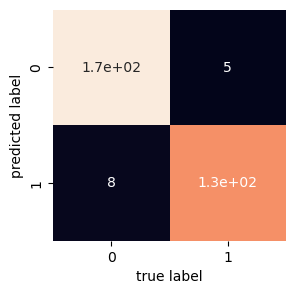

In [88]:
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, predictions),
                 annot=True, # Annotate the boxes
                 cbar=False)
plt.xlabel("true label")
plt.ylabel("predicted label");

<h4><font color=darkslategray> Test model new data </font></h4>

In [89]:
model.predict(["CM.com is a dynamic organization of over 300 developers divided over 20 teams, we are a leading software company. Team responsibilities vary from deep backend development to more user experience-oriented full-stack development. CM.com is a luxurious position to expand in multiple teams, therefore allowing you to work for a team and product that suits you the best.We offer opportunities for a diverse set of programming languages as we code in back end in C#, Java, PHP, and Go. Also we make use of a variety of front end frameworks like Angular, React, Vue.js etc. We are always upgrading our tech stack and looking for innovation and improvements. We work in an agile environment with experienced developers, product owners, UX designers, and more."])

array([0], dtype=int64)

In [90]:
model.predict(["competing salary"])

array([1], dtype=int64)

In [91]:
model.predict(["Join a team that’s passionate about creating and fostering partnership. With careers at Dow, we take time to explore questions and talk to each other. We love to learn and collaborate. Our people are driven by limitless curiosity.We are an innovative, customer centric, inclusive, and sustainable materials science company.- Employing 36,500 individuals- Across 109 manufacturing sites- In over 31 countriesOur portfolio of products and solutions include:Plastics: With new technology trends, our plastic additives can be experienced in many everyday items including vinyl, blow-molding bottles, film, rigid containers, PVC plastics, siding, decks and rails, foam pipes and profile formulations, window frames and high-efficiency lubricants.Industrial intermediates: As the product of a reaction that is beneficial when used as a precursor chemical for another product, industrial intermediates can take on many shapes and forms. Ours are used in home comfort and appliance, building and construction, adhesives and lubricants, and more.Coatings: Whether it’s a water-based coating or solvent-based coating, a thin film is deposited on materials to enhance specific properties such as enhanced performance, durability, aesthetics, and sustainability.Silicone businesses: Our silicone-based materials can withstand more demanding applications, from those operating at extreme temperatures, to those under harsh environmental conditions for long periods of time.Learn more about our partnerships, collaborations and innovations on LinkedIn (@Dow) or Twitter (@DowNewsroom).Our customer service team an “empowered team” that manages the order portfolio of a defined set of customers with whom they build and maintaining strong relationships. Located at Diamond Center in Terneuzen (NL) – a recently constructed building designed to inspire 1,100 employees of over 50 different nationalities to bring innovative solutions to Europe, Africa, Middle East, and India - our team is passionate about helping our customers in the region and collaborating closely with functional partners (Manufacturing, Marketing & Sales, Supply Chain, Logistics, etc.).By helping our customers compete and grow, we ensure our own growth and success. Do you see yourself becoming a Dow ambassador while exceeding the customer expectations and experience in an environment of inclusion, diversity, and integrity?"])

array([0], dtype=int64)

In [92]:
# X = df_text["text"]
# y = df_text["fraudulent"]

# # Random seed for reproducibility
# np.random.seed(42)

# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     y, 
#                                                     test_size=0.2)

# model = Pipeline([("tfidf", TfidfVectorizer()),
#                     ("clf", GaussianNB())])

# model.fit(X_train, y_train)

In [93]:
predictions = model.predict(X_test)

<h3><font color=slateblue> Improving the model </font></h3>

Use hyperparameter tuning to improve the model

<h4><font color=darkslategray> Get LinearSVC model parameters </font></h4>

In [94]:
LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

<h4><font color=darkslategray> Use GridSearchCV to tune the model </font></h4>

In [104]:
# Different hyperparameters for our LinearSVC model
lin_svc_grid = {"clf__C": [0.1, 1, 10, 100, 1000],
                "clf__penalty": ["l2"],
                "clf__loss": ["squared_hinge"],
               "clf__dual": [False, True],
               "clf__multi_class": ["ovr", "crammer_singer"],
               "clf__class_weight": ["balanced"],
               "clf__max_iter": [12000]}

# Setup grid hyperparameter search for LinearSVC
lin_svc_reg = GridSearchCV(model,
                         param_grid=lin_svc_grid,
                         cv=5,
                         verbose=True)

# Fit grid hyperparameter search model
lin_svc_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


<h4><font color=darkslategray> Get the best found parameters </font></h4>

In [102]:
lin_svc_reg.best_params_

{'clf__C': 1,
 'clf__class_weight': 'balanced',
 'clf__dual': False,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 12000,
 'clf__multi_class': 'crammer_singer',
 'clf__penalty': 'l2'}

<h4><font color=darkslategray> Score the best parameters </font></h4>

In [103]:
lin_svc_reg.score(X_test, y_test)

0.9529780564263323

Since the score of the best parameters are not better than the default parameters, I will keep using the default parameters.

In [98]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def visualize_word_freq(input_data,max_words,title_pre,tfidf=False):
    """ 
    Input data should be a list of docs.
    Each doc is represented by one whole string (with preprocessing, eg.remove markups)    
    """
    # Plot configuration
    plt.style.use("ggplot")
    plt.rcParams['axes.titlesize'] = 32
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    plt.rcParams['xtick.labelsize'] = 22
    
    if tfidf:
        vectorizer = TfidfVectorizer(max_features=max_words,stop_words='english',use_idf=True)
        TITLE = title_pre+" - "+"Most Freq Words (TFIDF)"
    else:
        vectorizer = CountVectorizer(max_features=max_words,stop_words='english')
        TITLE = title_pre+" - "+"Most Freq Words"
        
    mat = vectorizer.fit_transform(input_data)
    
    pd.DataFrame(mat.sum(axis=0).T,
             index=vectorizer.get_feature_names_out(),
             columns=['freq']).sort_values(by='freq',
                                           ascending=False).plot(kind='bar',title=TITLE)

In [99]:
df_real = df_text[df_text["fraudulent"] == 0]
df_fake = df_text[df_text["fraudulent"] == 1]

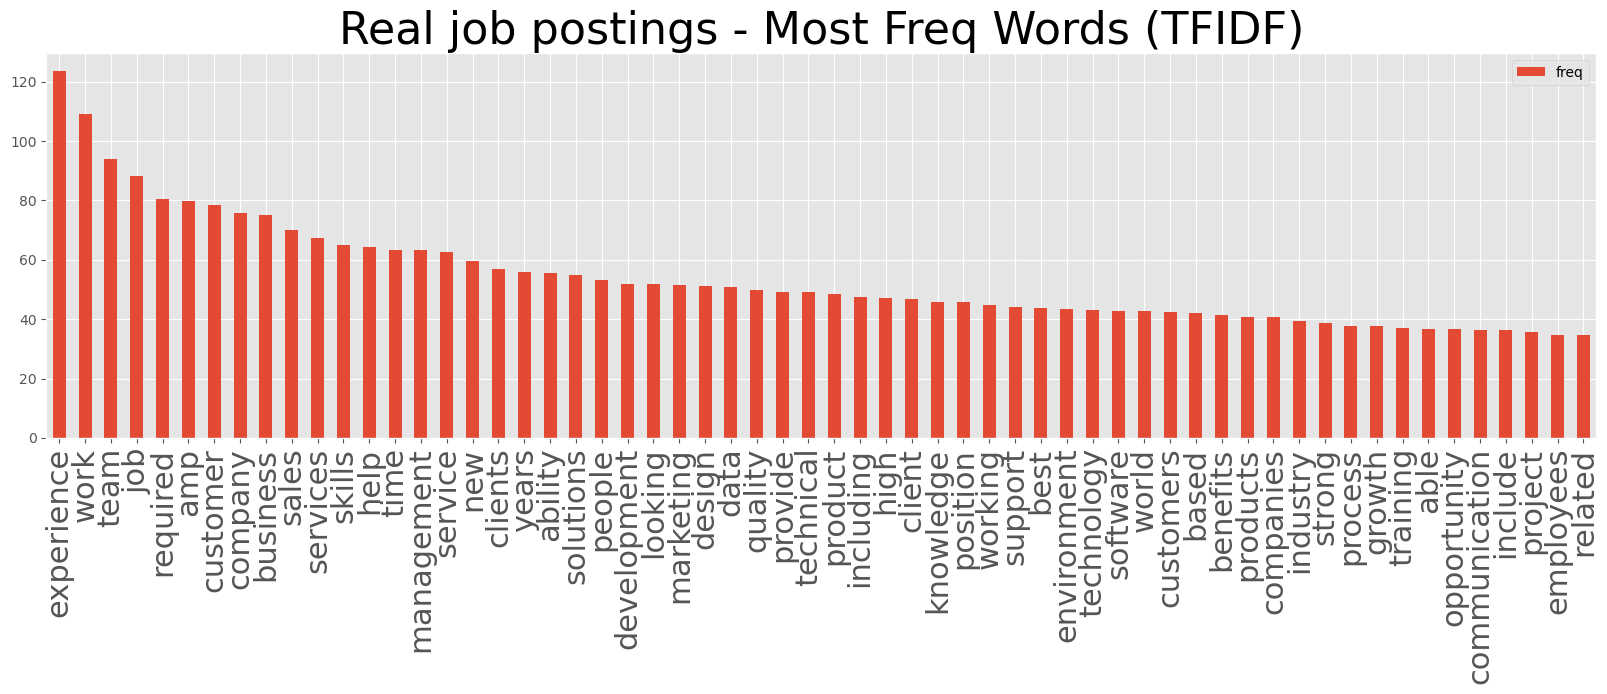

In [100]:
visualize_word_freq(df_real.text, 60, "Real job postings", True)

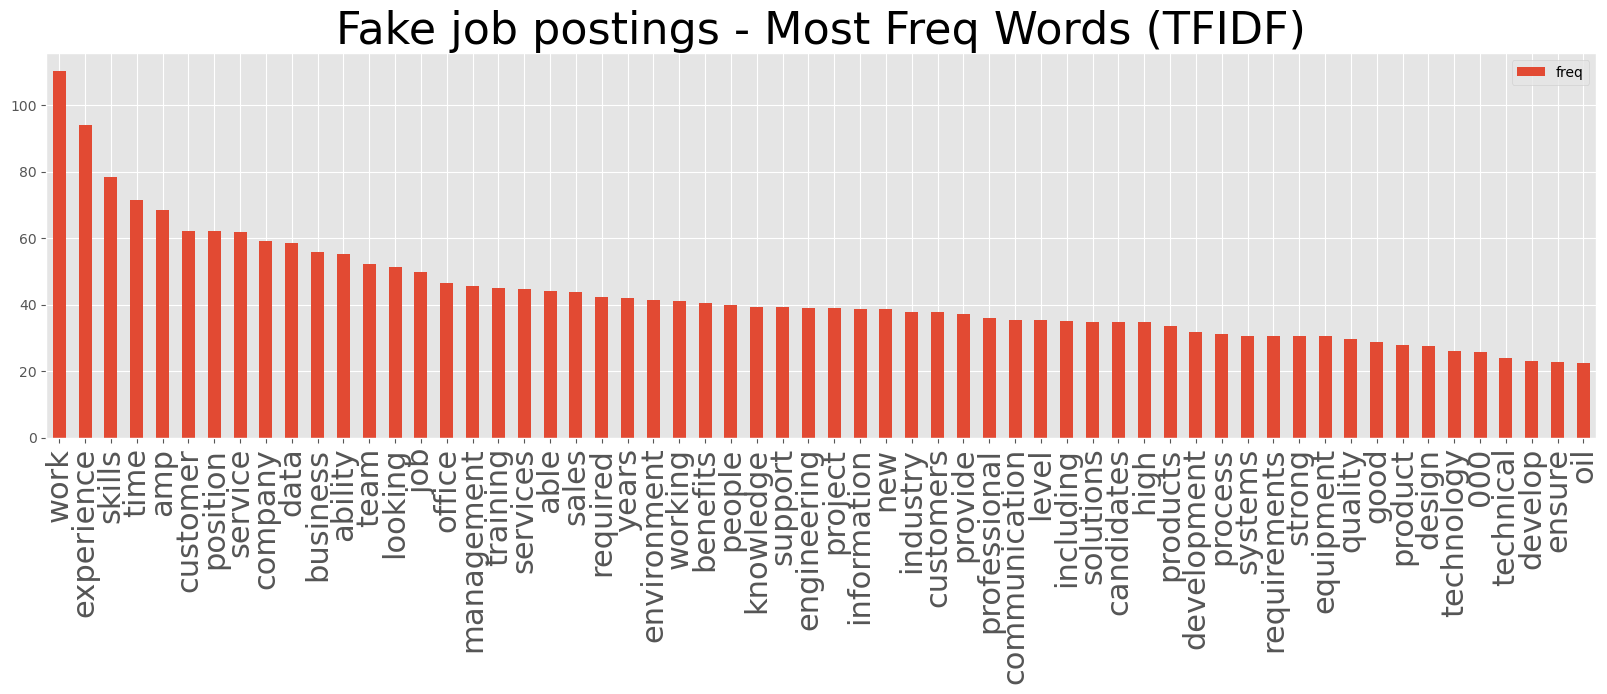

In [101]:
visualize_word_freq(df_fake.text, 60, "Fake job postings", True)

#### 